# Comparison of the Different Experimental Setups
- number of initial chains = 7
- merge after every 2 steps

In [1]:
import json
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib.patches import Patch
import pandas as pd
import numpy as np

In [2]:
# All experiments relevant for this notebook
experiments = ["b1_2", "n1_2", "n2_2", "n3_2", "m1_2", "m2_2", "m3_2"]

path_to_experiments = "../experiments_results"
required_files = [
    "{name}.jsonl",
    "{name}_em_results.jsonl",
    "{name}_llm_comparison_results.jsonl",
    "{name}_roscoe.jsonl",
    "{name}_roscoe_results.tsv",
    "{name}_bert_score_results.jsonl",
    "{name}_f1_results.jsonl",
]

In [3]:
# Check which experiment folders exist
existing_folders = []

for e in experiments:
    folder_path = os.path.join(path_to_experiments, e)
    if os.path.isdir(folder_path):
        existing_folders.append(e)
    else:
        print(f"ERROR {e} folder does not exist")

print()
# Check required files in existing folders
complete_folders = []
for e in existing_folders:
    folder_path = os.path.join(path_to_experiments, e)
    missing_files = []
    for file_template in required_files:
        file_name = file_template.format(name=e)
        file_path = os.path.join(folder_path, file_name)
        if not os.path.isfile(file_path):
            missing_files.append(file_name)
    if not missing_files:
        complete_folders.append(e)
    else:
        print(f"ERROR {e} has missing files")
        print(missing_files)
        print()

In [4]:
print("Folders with all required files:")
print(complete_folders)

Folders with all required files:
['b1_2', 'n1_2', 'n2_2', 'n3_2', 'm1_2', 'm2_2', 'm3_2']


## Analysis of Baseline

Average number of reasoning steps: 5.02
Median number of reasoning steps: 5.00


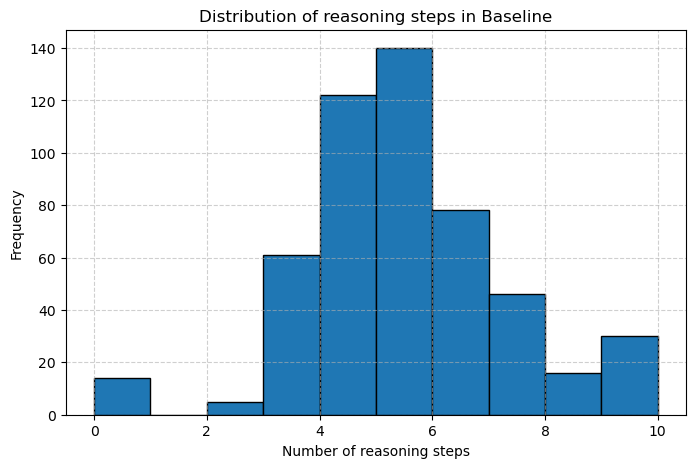

In [5]:
reasoning_lengths = []
p = os.path.join(path_to_experiments, "b1_2", "b1_2.jsonl")
with open(p, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        reasoning = data.get("reasoning", "")
        lines = reasoning.strip().split("\n")
        n_lines = len([l for l in lines if l.strip()])
        reasoning_lengths.append(n_lines)

avg_length = sum(reasoning_lengths) / len(reasoning_lengths)
print(f"Average number of reasoning steps: {avg_length:.2f}")
median_length = np.median(reasoning_lengths)
print(f"Median number of reasoning steps: {median_length:.2f}")

# Plot the distribution of reasoning lengths
binning = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
reasoning_lengths_array = [[l] for l in reasoning_lengths]
binned = binning.fit_transform(reasoning_lengths_array).flatten()

plt.figure(figsize=(8, 5))
plt.hist(reasoning_lengths, bins=range(min(reasoning_lengths), max(reasoning_lengths)+2), edgecolor='black')
plt.xlabel("Number of reasoning steps")
plt.ylabel("Frequency")
plt.title("Distribution of reasoning steps in Baseline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Report of Evaluation Results

In [6]:
groups = [
    ("B1", ["b1_2"]),
    ("N1      M1", ["n1_2", "m1_2"]),
    ("N2      M2", ["n2_2", "m2_2"]),
    ("N3      M3", ["n3_2", "m3_2"])
]

color_map = {
    "b1_2": "#d1495b",  # none
    "n1_2": "#edae49",  # entailment-based
    "n2_2": "#edae49",
    "n3_2": "#edae49",
    "m1_2": "#00798c",  # embedding-based
    "m2_2": "#00798c",
    "m3_2": "#00798c"
}

def compute_accuracy(exp, metric_file_name="_em_results.jsonl", metric_name="predicted"):
    file_path = os.path.join(path_to_experiments, exp, f"{exp}{metric_file_name}")
    if not os.path.isfile(file_path):
        print(f"ERROR: {file_path} not found. Defaulting to 100% accuracy.")
        return 1.0
    total = 0
    sum = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            total += 1
            sum += data.get(metric_name, False)
    if total == 0:
        print(f"ERROR: {file_path} has no data. Defaulting to 100% accuracy.")
        return 1.0
    return sum / total

def compute_roscoe_metric(exp, metric_file_name="_roscoe_results.tsv", metric_column="faithfulness"):
    file_path = os.path.join(path_to_experiments, exp, f"{exp}{metric_file_name}")
    if not os.path.isfile(file_path):
        print(f"ERROR: {file_path} not found. Defaulting to 100% value.")
        return 1.0
    df = pd.read_csv(file_path, sep=r'\s+', engine='python')
    if metric_column not in df.columns:
        print(f"ERROR: Column {metric_column} not found in {file_path}. Defaulting to 100% value.")
        return 1.0
    if len(df) == 0:
        print(f"ERROR: {file_path} is empty. Defaulting to 100% value.")
        return 1.0
    return df[metric_column].mean()

def create_plot(metric_file_name="_em_results.jsonl", metric_column=None, ylabel="Score", title="Performance per Experimental Configuration", metric_name="predicted"):
    """
    Specify metric_column if using the Roscoe metric. Otherwise, set it to None.
    """
    group_labels = []
    all_scores = []
    all_colors = []

    for label, exps in groups:
        group_labels.append(label)
        group_scores = []
        group_col = []
        for exp in exps:
            if metric_column is None:
                score = compute_accuracy(exp, metric_file_name, metric_name)
            else:
                score = compute_roscoe_metric(exp, metric_file_name, metric_column)
            group_scores.append(score)
            group_col.append(color_map[exp])
        all_scores.append(group_scores)
        all_colors.append(group_col)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    x = range(len(groups))

    for i, (scores, colors) in enumerate(zip(all_scores, all_colors)):
        for j, (score, color) in enumerate(zip(scores, colors)):
            offset = -bar_width / 2 if len(scores) == 2 else 0
            offset += j * bar_width if len(scores) == 2 else 0
            ax.bar(i + offset, score, width=bar_width, color=color)

    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(group_labels)
    ax.set_xlabel("Experiment")
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 1)
    ax.set_title(title)

    legend_elements = [
        Patch(facecolor="#d1495b", label="None"),
        Patch(facecolor="#edae49", label="Entailment-based"),
        Patch(facecolor="#00798c", label="Embedding-based")
    ]
    ax.legend(handles=legend_elements, title="Clustering Method")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Accuracy of the final answer

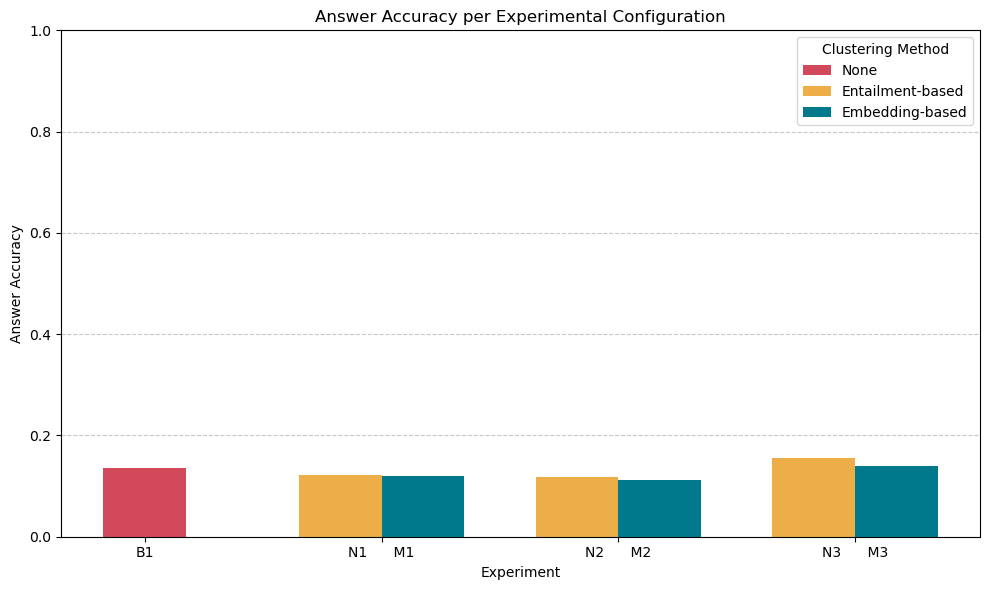

In [7]:
create_plot(metric_file_name="_em_results.jsonl", ylabel="Answer Accuracy", title="Answer Accuracy per Experimental Configuration")

### Accuracy of the reasoning process

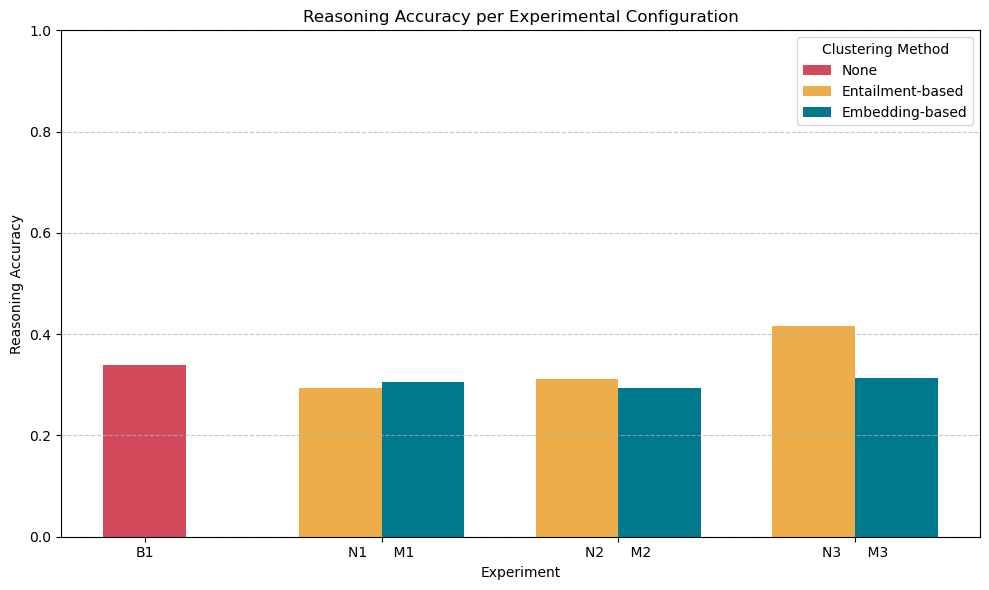

In [8]:
create_plot(metric_file_name="_llm_comparison_results.jsonl", ylabel="Reasoning Accuracy", title="Reasoning Accuracy per Experimental Configuration")

### Faithfulness of the final chain

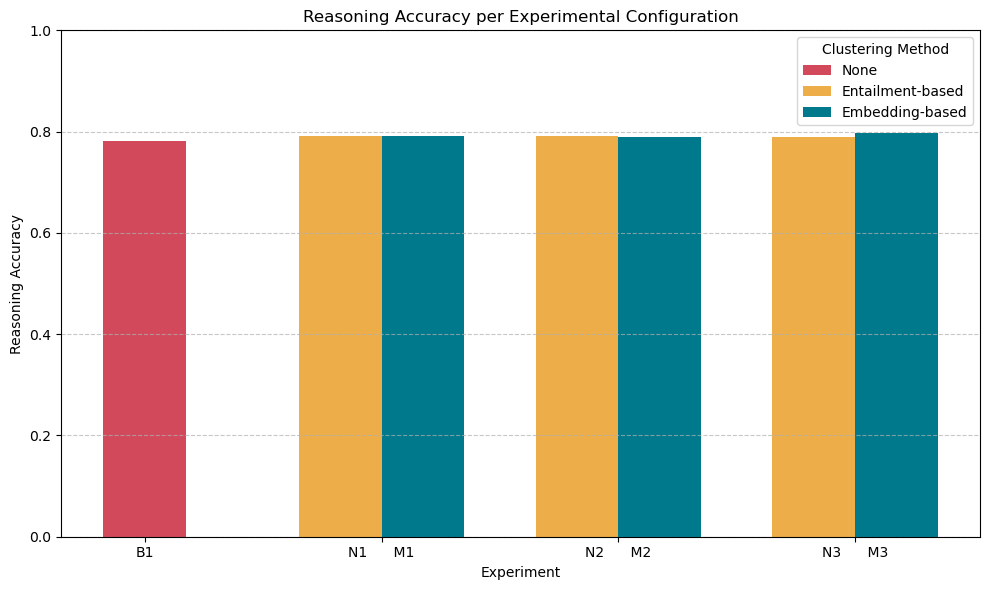

In [9]:
create_plot(metric_file_name="_roscoe_results.tsv", metric_column="faithfulness", ylabel="Reasoning Accuracy", title="Reasoning Accuracy per Experimental Configuration")

### Other metrics

#### Correctness of Reasoning Process

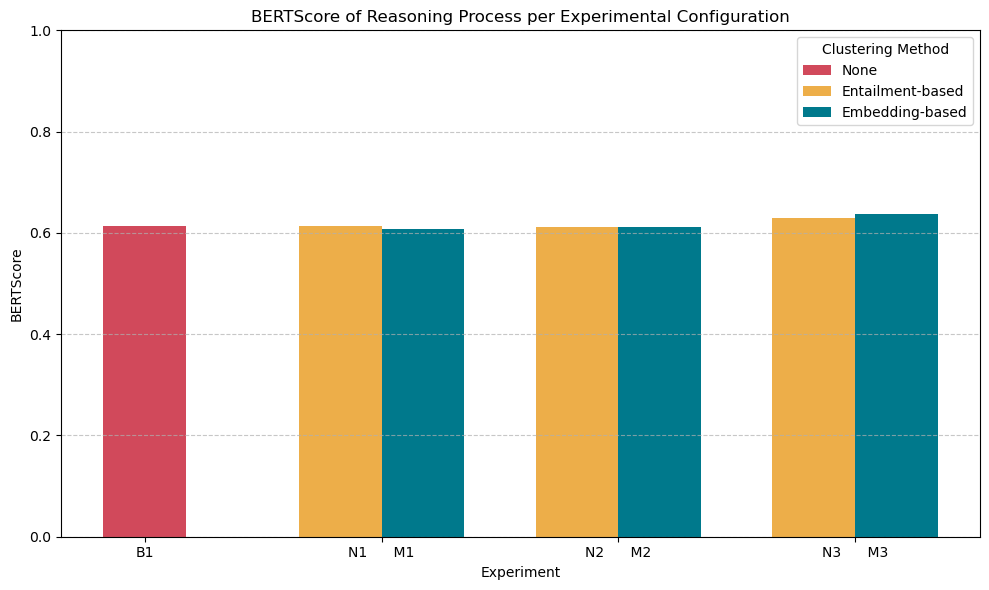

In [10]:
create_plot(metric_file_name="_bert_score_results.jsonl", ylabel="BERTScore", title="BERTScore of Reasoning Process per Experimental Configuration", metric_name="similarity")

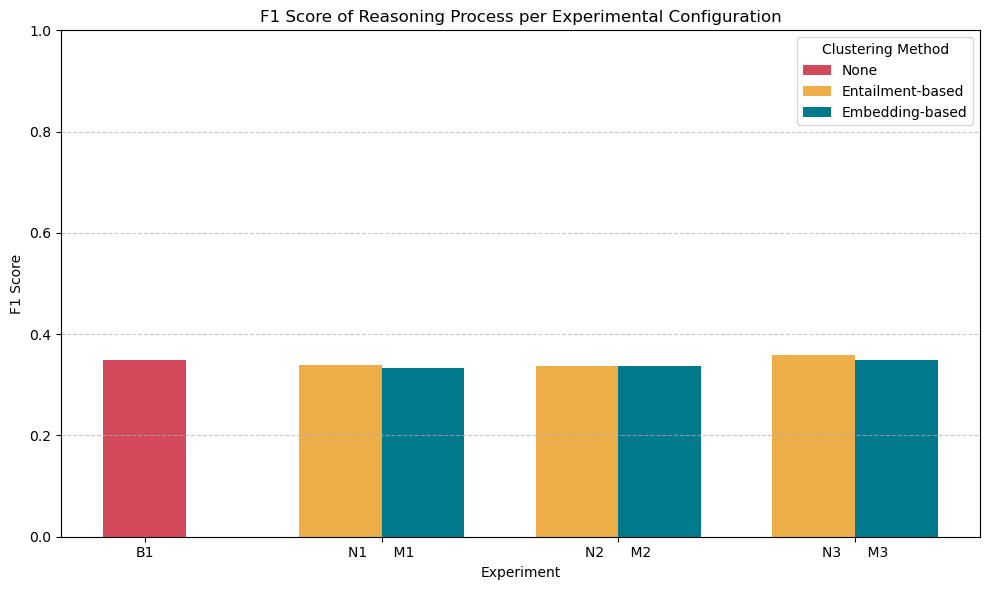

In [11]:
create_plot(metric_file_name="_f1_results.jsonl", ylabel="F1 Score", title="F1 Score of Reasoning Process per Experimental Configuration", metric_name="f1")

#### Chain Consistency and Quality

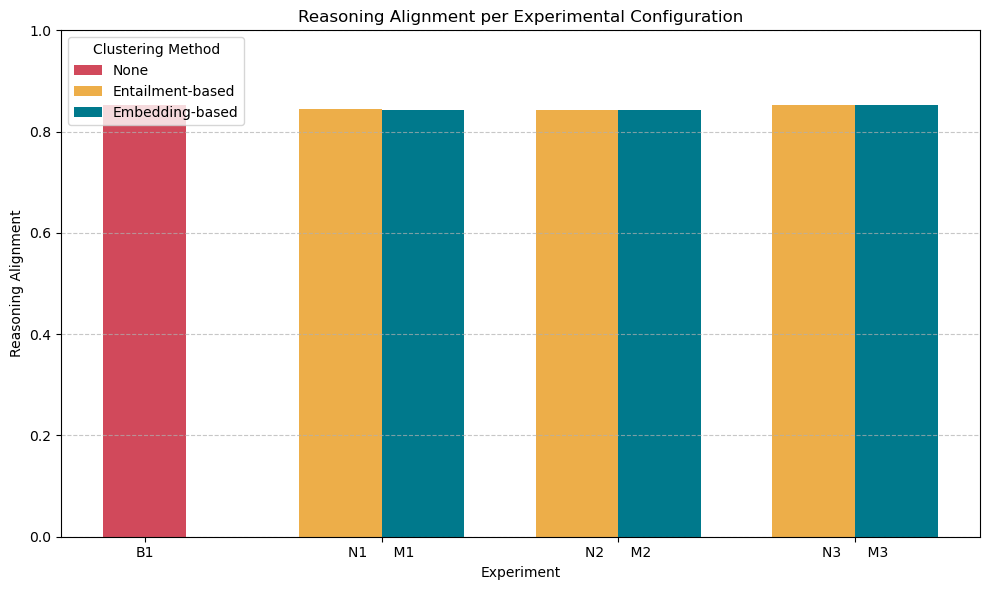

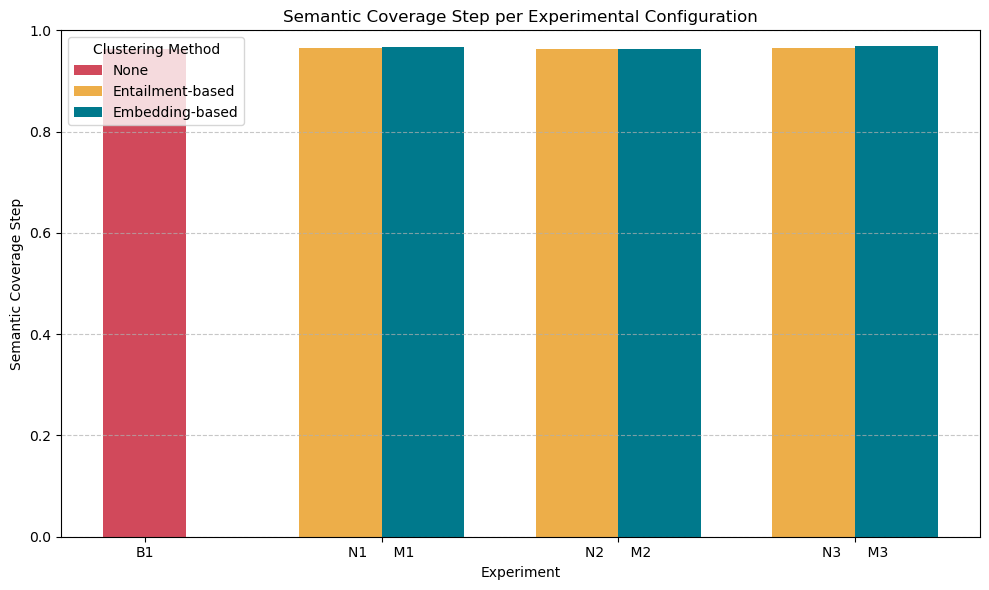

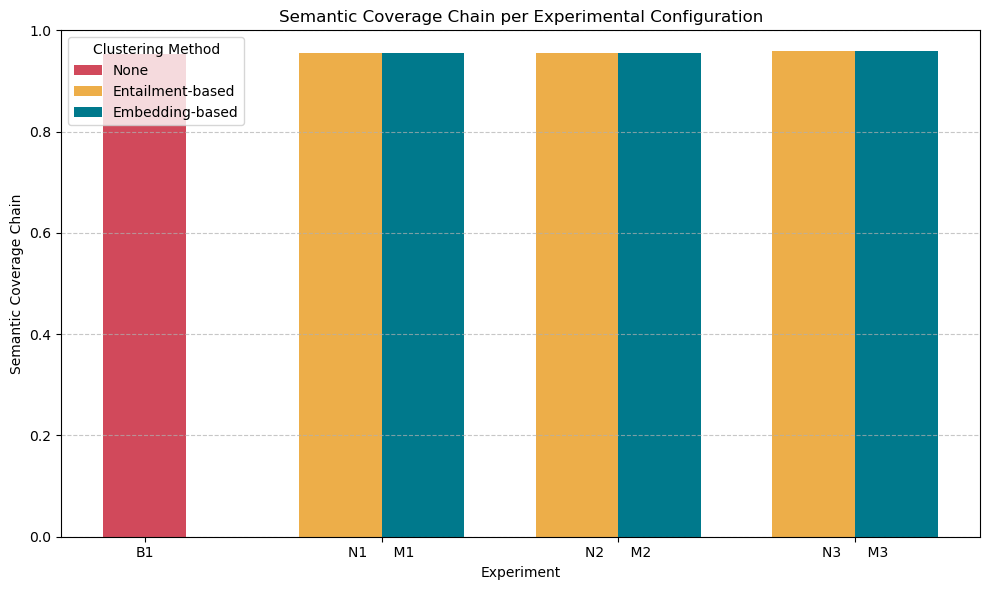

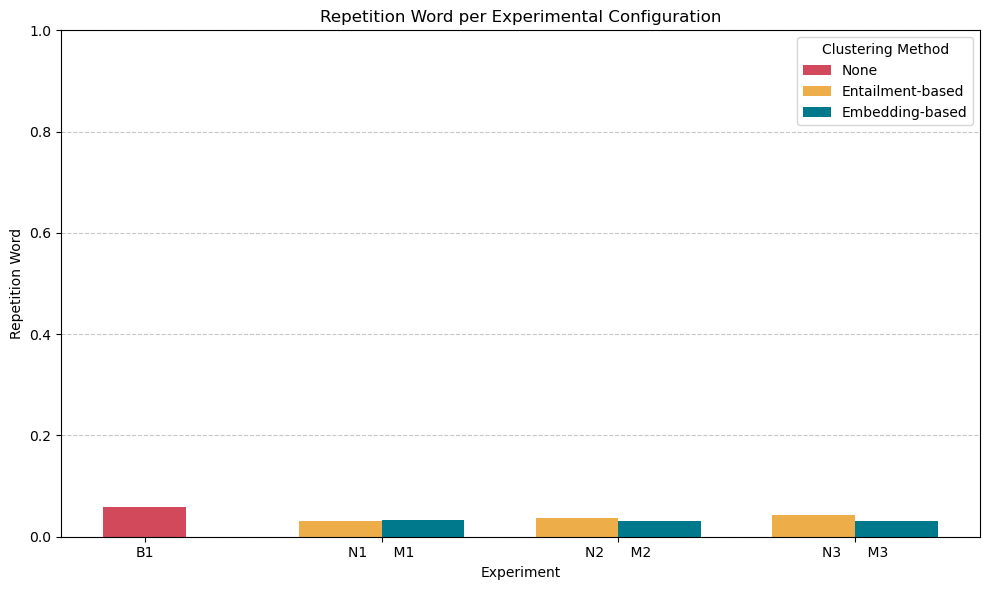

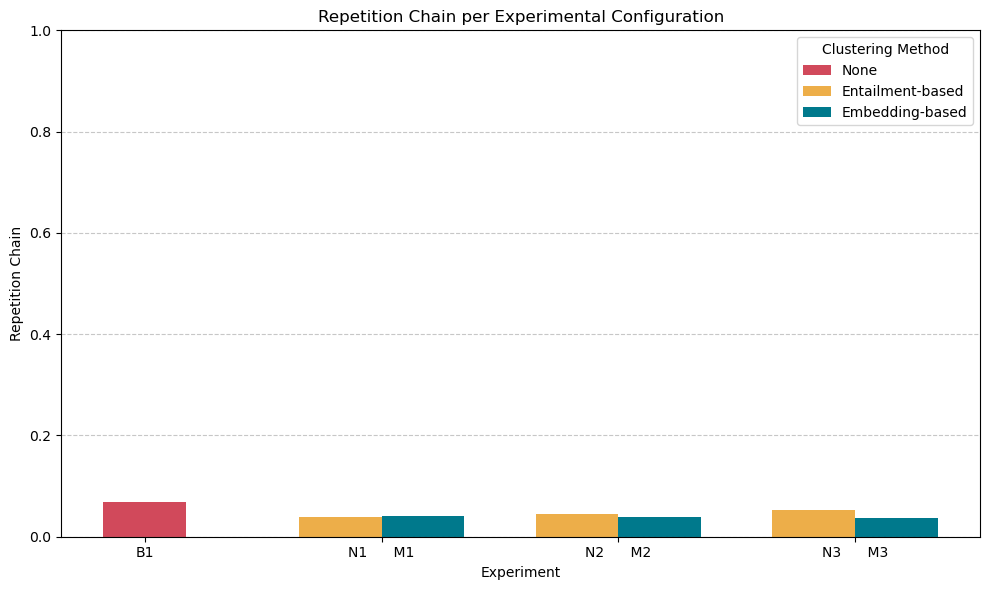

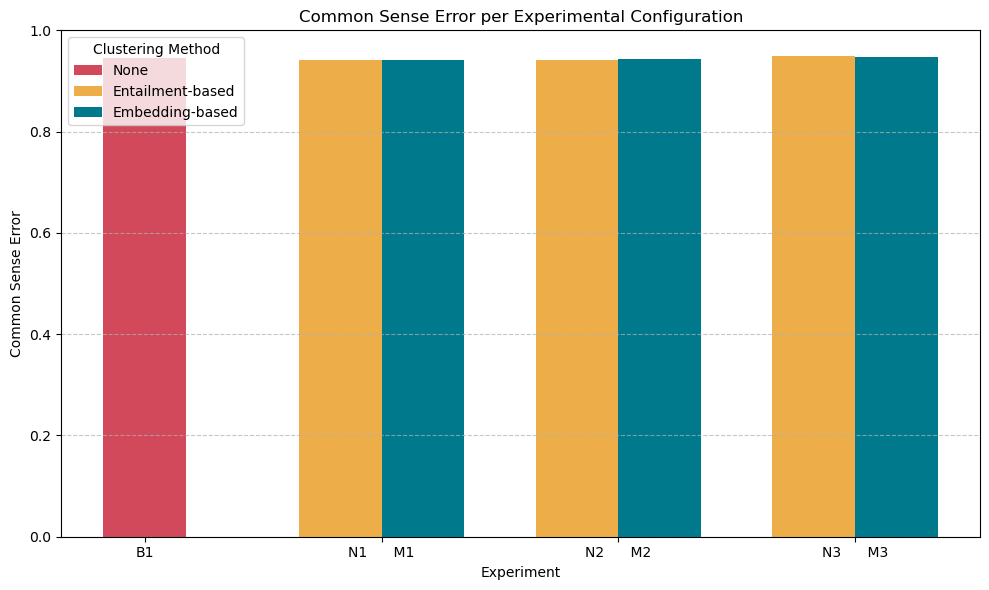

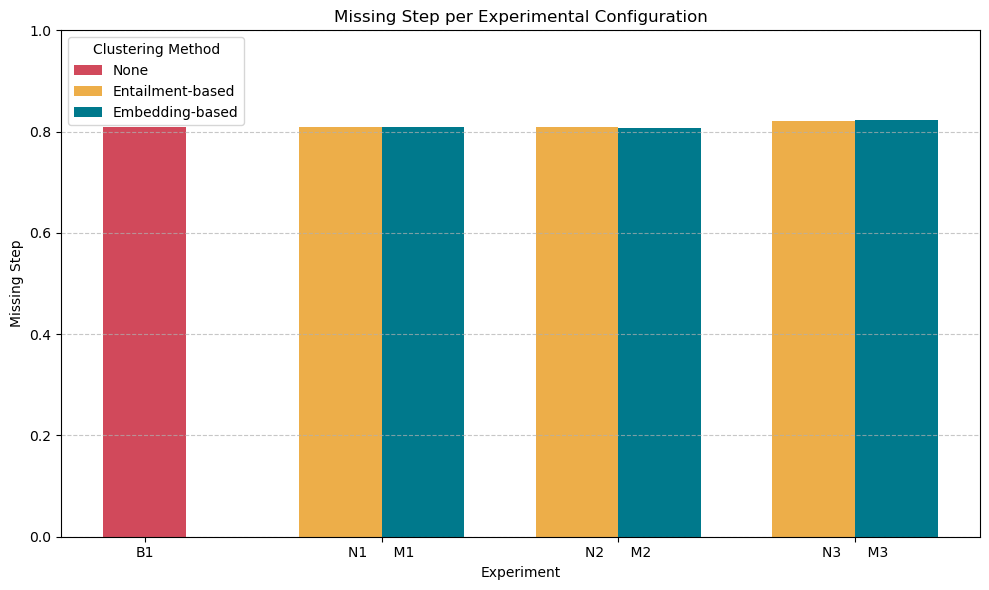

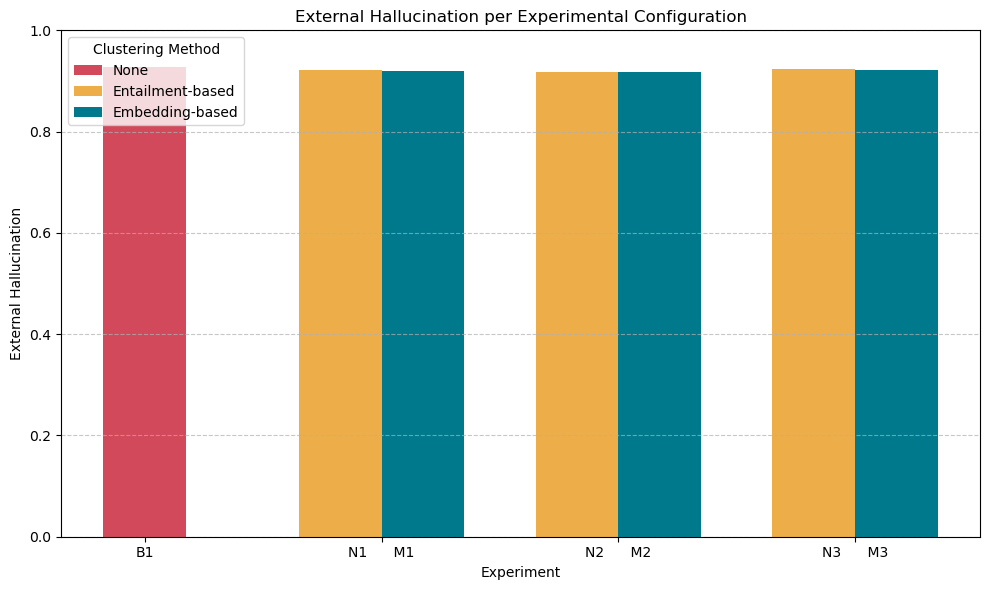

In [12]:
m = ["reasoning_alignment", "semantic_coverage_step", "semantic_coverage_chain", "repetition_word", "repetition_step", "common_sense_error", "missing_step", "external_hallucination"]
ylabels = ["Reasoning Alignment", "Semantic Coverage Step", "Semantic Coverage Chain", "Repetition Word", "Repetition Chain", "Common Sense Error", "Missing Step", "External Hallucination"]
title = [f"{i} per Experimental Configuration" for i in ylabels]

for i in range(len(m)):
    create_plot(metric_file_name=f"_roscoe_results.tsv", metric_column=m[i], ylabel=ylabels[i], title=title[i])